# Analysis of weather effects on Citibike trips

In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# import our helpers module. appending parent directory ("..") to sys.path might be necessary for helpers to be imported on some systems
import sys

sys.path.insert(0, "..")
import helpers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read data
* trips
* weather

In [ ]:
DATA_DIR = "../data/"
WEATHER_DIR = DATA_DIR + "weather/"

In [ ]:
%%time
trips = helpers.get_trips(2019, DATA_DIR)
trips["starttime"] = pd.to_datetime(trips["starttime"])
trips["stoptime"] = pd.to_datetime(trips["stoptime"])

trips

CPU times: user 39.2 s, sys: 27.5 s, total: 1min 6s
Wall time: 1min 9s


,tripduration,starttime,stoptime,startstationid,endstationid,bikeid,usertype,birthyear,gender
0,320,2019-01-01 00:01:47.401,2019-01-01 00:07:07.581,3160,3283,15839,Subscriber,1971,1
1,316,2019-01-01 00:04:43.736,2019-01-01 00:10:00.608,519,518,32723,Subscriber,1964,1
2,591,2019-01-01 00:06:03.997,2019-01-01 00:15:55.438,3171,3154,27451,Subscriber,1987,1
3,2719,2019-01-01 00:07:03.545,2019-01-01 00:52:22.650,504,3709,21579,Subscriber,1990,1
4,303,2019-01-01 00:07:35.945,2019-01-01 00:12:39.502,229,503,35379,Subscriber,1979,1
...,...,...,...,...,...,...,...,...,...
20551512,729,2019-10-31 23:59:12.190,2019-11-01 00:11:21.486,237,311,25725,Subscriber,1995,1
20551513,645,2019-10-31 23:59:17.047,2019-11-01 00:10:02.945,3259,461,39583,Customer,1969,0
20551514,257,2019-10-31 23:59:22.514,2019-11-01 00:03:40.260,3798,505,21240,Subscriber,1985,1
20551515,466,2019-10-31 23:59:23.171,2019-11-01 00:07:09.205,328,361,34916,Subscriber,1989,0


In [ ]:
# read weather
weather = pd.read_csv(WEATHER_DIR + "GHCN-Daily-Cleaned.csv", index_col=0)
weather["DATE"] = pd.to_datetime(weather["DATE"])
weather.set_index(weather["DATE"])
weather

,DATE,PRCP,SNOW,SNWD,TAVG_F,Normal Fog,Heavy Fog,Ice Fog,Fog,Thunder,Haze,Rain
0,2013-01-01,0.0,0.0,0.0,33.0,0,0,0,0,0,0,0
1,2013-01-02,0.0,0.0,0.0,27.5,0,0,0,0,0,1,0
2,2013-01-03,0.0,0.0,0.0,28.0,0,0,0,0,0,0,0
3,2013-01-04,0.0,0.0,0.0,33.5,0,0,0,0,0,0,0
4,2013-01-05,0.0,0.0,0.0,37.0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3361,2022-03-16,0.0,0.0,0.0,57.5,0,0,0,0,0,0,0
3362,2022-03-17,2.0,0.0,0.0,49.0,1,1,0,1,0,1,0
3363,2022-03-18,0.0,0.0,0.0,62.0,1,0,0,1,0,1,0
3364,2022-03-19,1.3,0.0,0.0,59.4,1,0,0,1,0,1,0


## Weather EDA

In [ ]:
trips_per_day = (
    trips.groupby(trips["starttime"].dt.dayofyear)["tripduration"]
    .count()
    .reset_index()
    .rename(columns={"starttime": "dayofyear", "tripduration": "counttrips"})
)
trips_per_day

,dayofyear,counttrips
0,1,21962
1,2,37797
2,3,41676
3,4,43922
4,5,17432
...,...,...
360,361,31808
361,362,28520
362,363,17968
363,364,12138


In [ ]:
start_2019 = pd.to_datetime("2019-01-01")
end_2019 = pd.to_datetime("2019-12-31")
weather_2019 = weather.loc[
    (weather["DATE"] >= start_2019) & (weather["DATE"] <= end_2019)
]

In [ ]:
w_trips = pd.merge(
    weather_2019,
    trips_per_day,
    left_on=weather_2019["DATE"].dt.dayofyear,
    right_on="dayofyear",
)
w_trips["Snowed on Day"] = w_trips["SNWD"].apply(lambda depth: depth > 0)
w_trips

,DATE,PRCP,SNOW,SNWD,TAVG_F,Normal Fog,Heavy Fog,Ice Fog,Fog,Thunder,Haze,Rain,dayofyear,counttrips,Snowed on Day
0,2019-01-01,1.5,0.0,0.0,48.5,1,0,0,1,0,0,0,1,21962,False
1,2019-01-02,0.0,0.0,0.0,37.5,0,0,0,0,0,0,0,2,37797,False
2,2019-01-03,0.0,0.0,0.0,40.6,0,0,0,0,0,0,0,3,41676,False
3,2019-01-04,0.0,0.0,0.0,41.0,0,0,0,0,0,0,0,4,43922,False
4,2019-01-05,12.7,0.0,0.0,44.0,1,0,0,1,0,0,0,5,17432,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2019-12-27,0.0,0.0,0.0,50.0,0,0,0,0,0,0,0,361,31808,False
361,2019-12-28,0.0,0.0,0.0,47.0,1,0,0,1,0,1,0,362,28520,False
362,2019-12-29,6.4,0.0,0.0,41.5,1,0,0,1,0,0,0,363,17968,False
363,2019-12-30,18.8,0.0,0.0,39.0,1,0,0,1,0,0,0,364,12138,False


Check trip relationship with average temperature

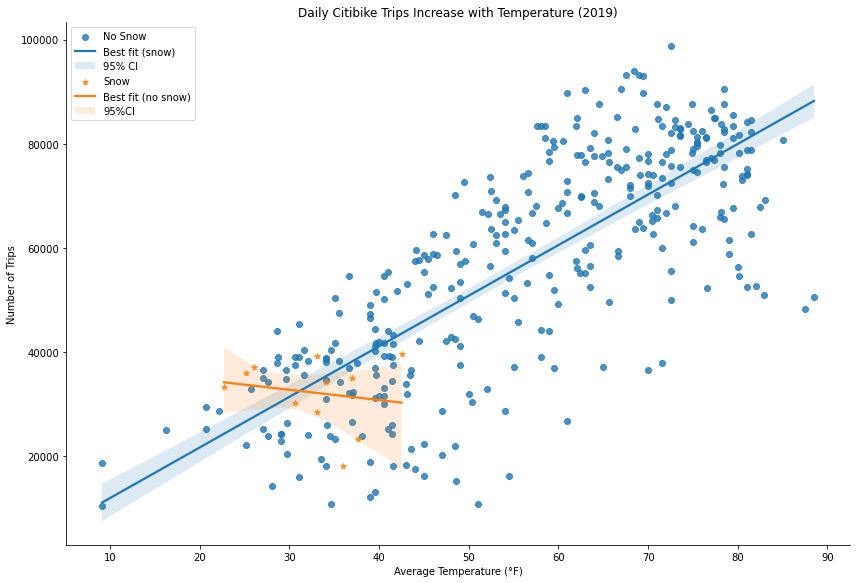

In [ ]:
g = sns.lmplot(
    data=w_trips,
    x="TAVG_F",
    y="counttrips",
    hue="Snowed on Day",
    markers=["o", "*"],
    height=8,
    aspect=1.5,
    facet_kws={"legend_out": False},
)
plt.title("Daily Citibike Trips Increase with Temperature (2019)")
plt.xlabel("Average Temperature (°F)")
plt.ylabel("Number of Trips")
plt.legend(
    labels=[
        "No Snow",
        "Best fit (snow)",
        "95% CI",
        "Snow",
        "Best fit (no snow)",
        "95%CI",
    ]
)
plt.show()

Check mean trips by weather condition

In [ ]:
g = w_trips[["DATE", "PRCP", "SNOW", "Fog", "Thunder", "Haze"]]
g.PRCP = g.PRCP.apply(lambda x: 1 if x > 0 else 0)
g.SNOW = g.SNOW.apply(lambda x: 1 if x > 0 else 0)
g.DATE = g.DATE.dt.dayofyear
g = g.rename(columns={"DATE": "dayofyear"})
g = g.merge(trips_per_day, how="left", on="dayofyear")
g

/var/folders/zx/f3rt3pyx58xg7vm_jv6_g3jh0000gn/T/ipykernel_30281/1081932836.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g.PRCP = g.PRCP.apply(lambda x: 1 if x > 0 else 0)
/var/folders/zx/f3rt3pyx58xg7vm_jv6_g3jh0000gn/T/ipykernel_30281/1081932836.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g.SNOW = g.SNOW.apply(lambda x: 1 if x > 0 else 0)
/var/folders/zx/f3rt3pyx58xg7vm_jv6_g3jh0000gn/T/ipykernel_30281/1081932836.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

,dayofyear,PRCP,SNOW,Fog,Thunder,Haze,counttrips
0,1,1,0,1,0,0,21962
1,2,0,0,0,0,0,37797
2,3,0,0,0,0,0,41676
3,4,0,0,0,0,0,43922
4,5,1,0,1,0,0,17432
...,...,...,...,...,...,...,...
360,361,0,0,0,0,0,31808
361,362,0,0,1,0,1,28520
362,363,1,0,1,0,0,17968
363,364,1,0,1,0,0,12138


In [ ]:
rain = (
    g.groupby("PRCP")["counttrips"]
    .mean()
    .reset_index()
    .rename(columns={"PRCP": "PRCP", "counttrips": "meantrips"})
)
rain.PRCP = rain.PRCP.apply(lambda x: "Rain" if x > 0 else "No Rain")

snow = (
    g.groupby("SNOW")["counttrips"]
    .mean()
    .reset_index()
    .rename(columns={"SNOW": "PRCP", "counttrips": "meantrips"})
)
snow.PRCP = snow.PRCP.apply(lambda x: "Snow" if x > 0 else "No Snow")

fog = (
    g.groupby("Fog")["counttrips"]
    .mean()
    .reset_index()
    .rename(columns={"Fog": "PRCP", "counttrips": "meantrips"})
)
fog.PRCP = fog.PRCP.apply(lambda x: "Fog" if x > 0 else "No Fog")

thunder = (
    g.groupby("Thunder")["counttrips"]
    .mean()
    .reset_index()
    .rename(columns={"Thunder": "PRCP", "counttrips": "meantrips"})
)
thunder.PRCP = thunder.PRCP.apply(lambda x: "Thunder" if x > 0 else "No Thunder")

haze = (
    g.groupby("Haze")["counttrips"]
    .mean()
    .reset_index()
    .rename(columns={"Haze": "PRCP", "counttrips": "meantrips"})
)
haze.PRCP = haze.PRCP.apply(lambda x: "Haze" if x > 0 else "No Haze")

In [ ]:
g = pd.concat([rain, snow, fog, thunder, haze], axis=0)
g.meantrips = g.meantrips.round()
g

,PRCP,meantrips
0,No Rain,60336.0
1,Rain,50397.0
0,No Snow,57438.0
1,Snow,27917.0
0,No Fog,58960.0
1,Fog,52750.0
0,No Thunder,55687.0
1,Thunder,63208.0
0,No Haze,56101.0
1,Haze,57409.0


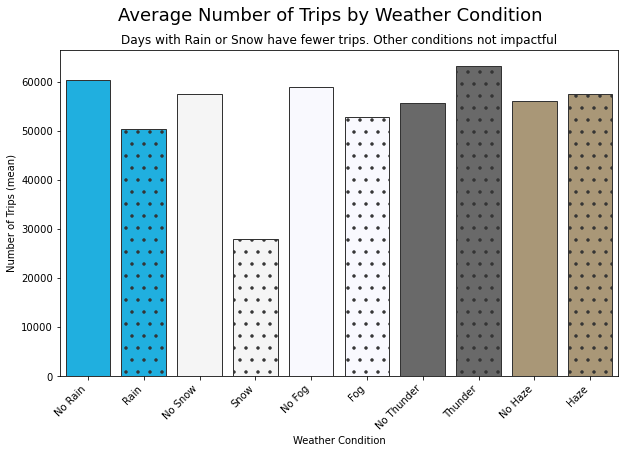

In [ ]:
# plot mean trips by weather condition
fig, ax = plt.subplots()
fig.set_size_inches((10, 6))
weather_colors = list(
    itertools.chain(
        *[
            [x, x]
            for x in ["deepskyblue", "whitesmoke", "ghostwhite", "dimgray", "xkcd:dust"]
        ]
    )
)
ax = sns.barplot(x=g.PRCP, y=g.meantrips, palette=weather_colors, edgecolor=".2", ax=ax)
for i, bar in enumerate(ax.patches):
    if i % 2 == 1:
        bar.set_hatch(".")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")

plt.xlabel("Weather Condition")
plt.ylabel("Number of Trips (mean)")
plt.suptitle("Average Number of Trips by Weather Condition", fontsize=18)
plt.title("Days with Rain or Snow have fewer trips. Other conditions not impactful")
plt.show()

In [ ]:
# fix bins later
bins = [0, 0.0001, 5, 20, 100]
w_trips["PRCP_bin"] = pd.cut(w_trips.PRCP, bins=bins, include_lowest=True)
w_trips.PRCP_bin.value_counts().sort_index()

(-0.001, 0.0001]    217
(0.0001, 5.0]        75
(5.0, 20.0]          50
(20.0, 100.0]        23
Name: PRCP_bin, dtype: int64

In [ ]:
g = (
    w_trips.groupby("PRCP_bin")["counttrips"]
    .mean()
    .reset_index()
    .rename(columns={"PRCP_bin": "PRCP_bin", "counttrips": "meantrips"})
)
g

,PRCP_bin,meantrips
0,"(-0.001, 0.0001]",60335.626728
1,"(0.0001, 5.0]",59056.933333
2,"(5.0, 20.0]",42391.660000
3,"(20.0, 100.0]",39557.956522


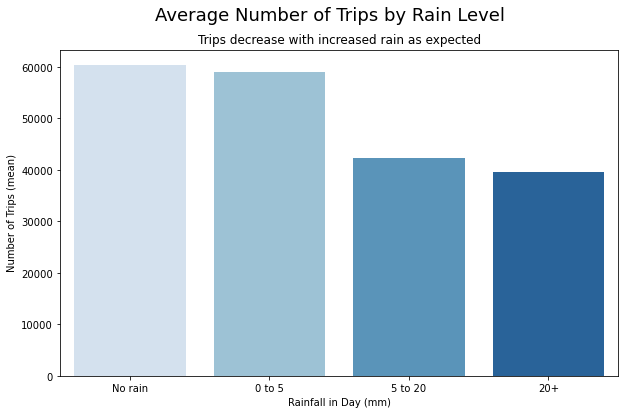

In [ ]:
# plot mean trips by weather condition
fig, ax = plt.subplots()
fig.set_size_inches((10, 6))
ax = sns.barplot(x=g.PRCP_bin, y=g.meantrips, palette="Blues", ax=ax)

ax.set_xticklabels(["No rain", "0 to 5", "5 to 20", "20+"])
plt.xlabel("Rainfall in Day (mm)")
plt.ylabel("Number of Trips (mean)")
plt.suptitle("Average Number of Trips by Rain Level", fontsize=18)
plt.title("Trips decrease with increased rain as expected")
plt.show()